In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

import lmfit

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

def display2dArray(arr, title='Data', showBars=True):
    img = plt.imshow(arr, origin='lower', interpolation='none', cmap='gray' )
    plt.title(title)
    if showBars: plt.colorbar(img, cmap='gray')

def displayImage(image, showMasks=True, showVariance=False, showPsf=False, showBars=True, isPsf=False):
    plt.figure(figsize=(8, 2.5))
    plt.subplot(1, 3, 1)
    ma = image.getMaskedImage().getArrays()
    display2dArray(ma[0], title='Data', showBars=showBars)
    if showMasks:
        plt.subplot(1, 3, 2)
        display2dArray(ma[1], title='Masks', showBars=showBars)
    if showVariance and not showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(ma[2], title='Variance', showBars=showBars)
    if showPsf:
        plt.subplot(1, 3, 3)
        display2dArray(image.getPsf().computeImage().getArray(), title='PSF', showBars=showBars)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

51
100.0
2.0


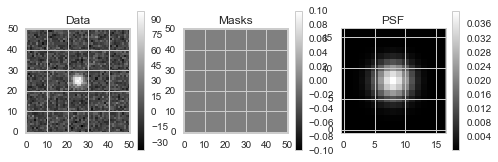

In [11]:
from lsst.meas.base.tests import TestDataset
#from meas_base_tests import TestDataset   ## my slightly modified version
import lsst.afw.geom as afwGeom

def makeStarImage_lsst(w=51, h=51, xc=25, yc=25, flux=2500, psfSigma=2., psfDim=17, noise=1.0, makeFootprint=False):
    bbox = afwGeom.Box2I(afwGeom.Point2I(0,0), afwGeom.Point2I(w-1, h-1))
    dataset = TestDataset(bbox, psfSigma=psfSigma, psfDim=psfDim, threshold=1.)
    dataset.addSource(flux=flux, centroid=afwGeom.Point2D(xc, yc), installFp=makeFootprint)
    exposure, catalog = dataset.realize(noise=noise, schema=TestDataset.makeMinimalSchema())
    #if noise > 0:
    #    exposure.getMaskedImage().getVariance().getArray()[:,:] = noise**2
    #    exposure.getMaskedImage().getImage().getArray()[:,:] \
    #        += np.random.randn(exposure.getHeight(), exposure.getWidth())*noise
    return exposure, catalog

exposure, catalog = makeStarImage_lsst(w=51, h=51, xc=25., yc=25., flux=2500, noise=10.)
print exposure.getWidth()
displayImage(exposure, showPsf=True)
print exposure.getMaskedImage().getArrays()[2].mean()
#%timeit exposure, catalog = makeStarImage_lsst(flux=2500, noise=10.)
#%timeit exposure, catalog = makeStarImage_lsst(flux=2500, noise=0.)
print exposure.getPsf().computeShape().getDeterminantRadius()

<class 'lsst.afw.detection.detectionLib.Psf'>


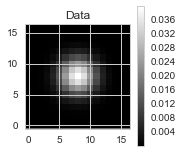

In [12]:
psf = exposure.getPsf()
print type(psf)
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
display2dArray(psf.computeImage().getArray())

Box2I(Point2I(2, 4), Extent2I(17, 17))

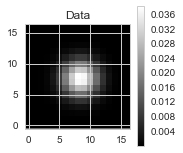

In [13]:
p2 = psf.computeImage(afwGeom.Point2D(10.4, 11.6)).convertF()
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
display2dArray(p2.getArray())
p2.getBBox()

0.999851
<class 'lsst.afw.image.imageLib.ImageF'> <class 'lsst.afw.image.imageLib.ImageF'>
Box2I((0, 0), (50, 50))
Box2I((2, 4), (18, 20))
Box2I((2, 4), (18, 20))
Box2I((2, 4), (18, 20))


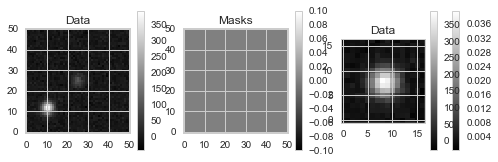

In [10]:
psfIm = p2.convertF()
print np.sum(psfIm.getArray())
psfIm *= 10000.
expIm = exposure.getMaskedImage().getImage()
print type(psfIm), type(expIm)

box = p2.getBBox()
subim = afwImage.ImageF(expIm, box, afwImage.LOCAL)

subim += psfIm
displayImage(exposure, showPsf=True)
display2dArray(subim.getArray())
print exposure.getBBox()
print subim.getBBox()
print p2.getBBox()
print psfIm.getBBox()

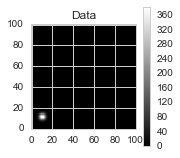

In [16]:
box = afwGeom.BoxI(afwGeom.PointI(0, 0), afwGeom.ExtentI(101, 101))
im = afwImage.ImageF(box)
box = p2.getBBox()
subim = afwImage.ImageF(im, box, afwImage.LOCAL)
subim += psfIm
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
display2dArray(im.getArray())